In [1]:
import cv2
import PIL
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

# WRITE ABOUT MIXED PRECISION AND STUFF (QNA EXCEL에 있다)

In [2]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# We'll use CIFAR-10 (RGB image set with 10 classes)
* pytorch에 이미 있따



# 0. Utils (무시해도 됨, 크게 중요하지 않음)

### 잡지식
Q : when to do instance.method() or instance.method ???

A : x.shape에서 shape는 x 객체의 attribute이고, max()는 x 객체의 method입니다.
암기의 영역 (but  뉘앙스 : shape는 어떤 property이고 max()같은거는 우리가 행해주는 것이다 (굳이 이것이 attribut로 저장되지는 않을 가능성이 높다))(즉 어떤 object의 essential한 요소이면 attribute일 확률이 높으니, `()`가 없을 확률이 높다)

In [4]:
def plot_dataset(dataloader, grid_width=8, grid_height=2, figure_width=12, figure_height=3, y_hats=None):
    images, labels = next(iter(dataloader)) #dataloader에서 tensor을 loading하는 법
    f, ax = plt.subplots(grid_height, grid_width)
    f.set_size_inches(figure_width, figure_height)
    img_idx = 0
    for i in range(0, grid_height):
        for j in range(0, grid_width):
            image = images[img_idx]
            label = labels[img_idx]
            title_color = 'k'
            if y_hats is None:
                label_idx = int(label)
            else:
                label_idx = int(y_hats[img_idx])
                if int(labels[img_idx]) != label_idx:
                    title_color = 'r'
            label = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][label_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label, color=title_color)
            ax[i][j].imshow(np.transpose(image, (1, 2, 0)), aspect='auto')
            img_idx += 1
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)
    plt.show()

# 1. Load Data : CIFAR-10
BIG PICTURE : Lab1 에서 처럼 `CustomDataset`을 만들어준 후, `DataLoader`을 사용해서 `train_loader`, `test_loader` instance를 만들 것이다!

    


## 1.1 Creating `CustomDataset`

LAB1 에서 했듯이, `__init__`, `__len__`, `__getitem__` 는 기본으로 정의해줘야한다

* `__init__` : `self.data = datasets.CIFAR10(train = train, download = True, root = "./CIFAR_10")` download CIFAR10 and save it at "./CIFAR_10"
* `__len__` , `__getitem__` : 설명 생략 

<br>

### **추가적으로 collate_fn을 정의해주자**

(collate function : batch image set을 받아서 batch tensor 화 시켜주는 것

* collate_fn : image를 tensor로 바꿔서 batch단위로 모델에 주는 것
    * input : a BATCH of DATA (not the whole dataset!)(`collate_fn = train_dataset.collate_fn` 이라고 나중에 DataLoading할때 불러서 batch size를 넣어준다
    * output : a BATCH of (transformed) TENSORS 
        * 여기서는 `transform()` class의 `transform.ToTensor()`을 사용했다 (image를 tensor로 바꾸기 위해서 이미지를 dimension reordering (R, W, C) $\rightarrow{}$ (C, H, W) and noramlization를 한방에 하는 것)(cropping등등을 추가적으로 할 수 도 있다)
    
<br>

**`collate_fn`을 우리는 다음 steps로 할 것이다:**

0. loop over all the samples (x,y) of a given BATCH of IMAGES (over `data` that is given as input)
1. make x, y into TENSORS and apply any transformations if required)
    * use `transform.ToTensor()` to change PIL to Tensor
2. x,y를 하나씩 `batch list of images`로 더하기 (list of tensors) (append to list)
    * use 
3. list of tensors -> tensor of tensors로 만든다 (tensor of tensors) (list를 tensorize하기)
4. input/output을 float/long 화 (ipnut/output을 그렇게 해줘야 torch가 된다고함) => ASK

<br>

* 참고로 `collate_fn`정의할때 한가지 특이한 것을 했다
    * `self.transform` : input data에 transformation을 하기 위해 쓰임 (`transform = None`이 아닐떄만 작동하게 함)(the if staement in collate_fn)
        * ex : data augmentation (cropping, etc)
        * optional     


<br> 

### transform = None, and if XXX is not None:

* `long` : `int` with infinite length
    * 그래서 이것으로 바꾸는게 코드 맨 밑에 있다 (input, label을 안해도 되기는 한데)
    * y가 원래 tensor여것 이것을 `int`로 바꿔줘야한다

<br>

## =====DO THIS DO THIS DO THIS (`torch.cat`여기)=====

* `torchcat`하는 이유 : [batch1 (tensor), batch2 (tensor), ..]인데 이 리스트도 tensor로 해야해서 맨 밑에 그 바꿔주는 cat같은 것을 하는 것! (즉 여러번 돌려서 cat하는게 아닌 list를 tensor로 바꾸기 위한 것)

* 즉, 첫번째 dimensio은 batch# 여야한다!

## ASK  : 
* input/output dtype requirements (float and log)
    * 왜 이렇게 해야하지? 이렇게 안하면 어디서 막히지?

In [5]:
### SOME BACKGROUND INFO 
data = datasets.CIFAR10(root = "./CIFAR_10", train = False , download = True)
print("data : ", data)

sample = data[0]
x_before = data[0][0]
y_before = data[0][1]

print("data[0] : ", data[0])
print("x_before (data[0][0]) : ", data[0][0],"\ny_before (data[0][1]) : ", data[0][1])

#2. changing them to tensors using transforms.ToTensor() (PIL => tensor)
print("\n=====changing them to tensors=====")
x_after = transforms.ToTensor()(x_before) #changes PIL -> tensor
y_after = torch.Tensor([y_before])

print("x_after : ", x_after.shape, type(x_after))
print("y_after : ", y_after.shape, type(y_after))

#실제 transformation전후 shape를 비교해보면 답이 나온다 (즉, transformation : (# of channels, height, width) 가 되도록 reshaping을 해준다)
print("\nshape before :", np.array(x_before).shape) #np.array()를 해줘야 PIL -> numpy가 되어 shape등을 볼 수 있다
print("shape after :", np.array(x_after).shape)

Files already downloaded and verified
data :  Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./CIFAR_10
    Split: Test
data[0] :  (<PIL.Image.Image image mode=RGB size=32x32 at 0x7FB5890B4D90>, 3)
x_before (data[0][0]) :  <PIL.Image.Image image mode=RGB size=32x32 at 0x7FB5890B4DF0> 
y_before (data[0][1]) :  3

=====changing them to tensors=====
x_after :  torch.Size([3, 32, 32]) <class 'torch.Tensor'>
y_after :  torch.Size([1]) <class 'torch.Tensor'>

shape before : (32, 32, 3)
shape after : (3, 32, 32)


In [6]:
BATCH_SIZE = 32
EPOCHS = 1

In [7]:
class CustomDataset(Dataset):
    def __init__(self, train, transform = None):  #, data_dir = './CIFAR_10') : 
        self.data = datasets.CIFAR10(train = train, download = True, root = "./CIFAR_10")
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    #batchify data 
    def collate_fn(self, data): #data will be 
        batch_x , batch_y = [], []
        
        #individual x, y (data/label)을 tensorize + batchify 하기
        for x, y in data:
            #1. make x,y into tensors and apply transformation if necessary (if transform = None이 아닐떄)
            if self.transform is not None: #if transform is given, use it
                x = self.transform(x)
            x = transforms.ToTensor()(x) # PIL => tensor 로 바꾸끼
            y = torch.Tensor([y]) #[y] not y because have to do list => tensor (int => tensor impossible)
        
            #2. add individual images together to make into a batch (by listizing it)
            batch_x.append(x)
            batch_y.append(y)
        #3. turn list,int into tensors by cat and stack (왜 둘이 다른거를 쓰는지는 생략)
        batch_x = torch.stack(batch_x)
        batch_y = torch.cat(batch_y)
        
        #4. input/output을 float/long 화
        batch_x = batch_x.float()
        batch_y = batch_y.long() #그냥 int로 해도 될꺼래
        
        return batch_x, batch_y

## 1.2 Load the `CustomDatasets` using `DataLoader` 
* 이 파트는 생략, 이미 전에 했다
* 한가지 특이점 : `collate_fn`을 우리가 정해준 `test_dataset.collate_fn` method를 통해 가져온다
    * 이것 덕분에 위에서 dastaset 에서 batchsize만큼의 `data`가 collate_fn에 들어가게 되는 것! (not the whole dataset)

In [8]:
## Load CIFAR-10 Dataset using DataLoader

#1. CREATE DATASET instance
train_dataset = CustomDataset(train = True) #train = True는 clss정의할때 했었다
test_dataset = CustomDataset(train = False)

#2. LOAD the dataset using DATALOADER (with the pre-defined BATCHSIZE and collate fn)
train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,
                          shuffle = True, collate_fn = train_dataset.collate_fn) #here, we used the collate_fn method we pre-defined in the CustomDataset

test_loader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE,
                         shuffle = True, collate_fn = test_dataset.collate_fn) 

Files already downloaded and verified
Files already downloaded and verified


len(train_dataset) :  50000
len(train_loader) :  1563
len(train_dataset)/BATCH_SIZE 1562.5
===train_loader samples===


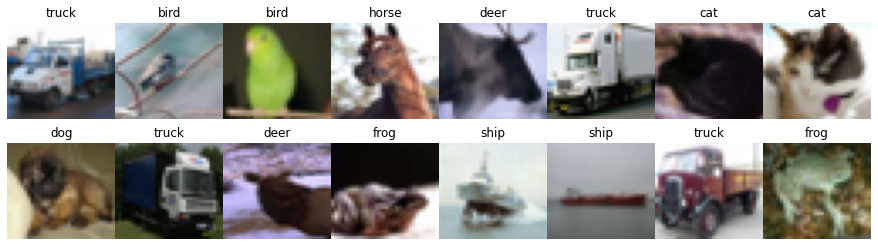

===test_loader samples===


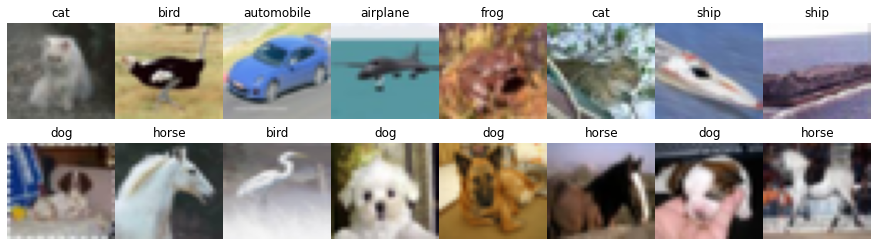

In [9]:
#check the dataloader/batch things
#train의 원래 length
print("len(train_dataset) : ", len(train_dataset))

#train_loader을 거친 후의 length (i.e. batchify 된 후에)
print("len(train_loader) : ",len(train_loader))

#밑의 값의 int => 위의 값 (왜냐하면 batch size만큼 되니)
print("len(train_dataset)/BATCH_SIZE",len(train_dataset)/BATCH_SIZE) 

#실제로 보자 (utils로 정의했던 것 써서)
print("===train_loader samples===")
plot_dataset(train_loader)

print("===test_loader samples===")
plot_dataset(test_loader)

# 2. build CNN Model Using PyTorch


## 2.1. Define Model

`nn.Conv2d` : following things are needed
* kernel size (local 얼마나 볼지)
* `in_channels`, `out_channels` : number of channels (concurrent layers) 
    * `out_channel` before = `in_channel` after이 되어야한다! (duh)

* nn.Linear과 다르게, parameter수 자체 (or width/height pixel 갯수 그 자체)를 넣어줄 필요는 없다! (다른정보들주면 얘가 알아서 유추함)
    * 따라서 만약 conv2d 여러개 거친 후 nn.Linear하고 싶으면 (ex MLP) : output갯수를 직접 계산해 줘서 nn.Linear()의 input layer 의 neuron 갯수로 그 값을 넣어야한다!
    
    
* required input shape: `[batch_size, channel 갯수, width, length]` 여야한다!
    * dimension tracking을 잘해야한다!

* conv layer 사이에서도 relu같은 것을 해야한다! (nonlinearity 필요함)(생각해보면 당연하기는 하다)

* train_loader.datset : train_loader만들때 쓰인 dataset을 불러온다!~(i.e. brings the 엄마 class)

## ASK :
* `nn.Linear` 과 다르게 `nn.Conv2d, nn.MaxPool2d`같은거는 input, output paraemter 갯수를 모름 => 그러면 나중에 CNN => MLP넘어갈때 갯수를 어떻게 새지? (특히, input사이즈가 달라지면 MLP파트 할때 새로 만들어야함..? (model을 뜯어 고쳐서)) 

A : 코딩하는 사람의 마음 (automatic 하게 update되도록 할 수도 있고 아니면 shape를 얻어서 그것을 직접 넣어주도록 할 수도 있다 (특히, brain image가 크기 때문에 model size를 적절히 잡아야 하는 경우도 있는데, 이떄 size를 쉽게 잡으려면 automaticgㅏ게 되도록 하는게 좋다)(this is called "soft coding", which is much better than "hard coding"(숫자 일일히 넣어주는 것)

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        #conv layers and max pooling
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3) #in : [32 x 3 x 32 x 34]
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride = 2)
        
        #MLP part (to make prediction)
        self.fc1 = nn.Linear(16*6*6, 64) #6*6*14는 maxppol결과가 16 channel 6*6 image여서 그것을 flatten한것임
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        #CNN, pooling part
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x) #pool 은 update안하는 그냥 하나의 과정이니 self.pool 여러번 reference해도 OK

        #MLP part (to do prediction) 
        x = x.reshape(-1, 16*6*6) #don't forget to flatten before putting it in MLP!! #or use x.numle() 
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x) #softmax to do probability prediction
        
        return x

## 2.2 Define Training/Testing Loop

### Lab1에서 했던 train/testing loop과 다른점
* use `tqdm`
* for loop (over epochs)를 train loop에서 하지 않고, 대신 trainloop을 over epoch으로 돌린다!

## Questions
1. optimizer.step()  를 하면서 optimize하는데, 이때 어떤 model을 어떤 gradient 결과로 optimize하는지 파이토치가 어떻게 알지? (optimizer 자체에서는 model에  대한 언급이 없으니)

    A : Ozptimizer 객체를 처음 선언할 때 `model.parameters()` 라고 하는데, 이떄 어떤 model의 weight를 업데이트할지를 입력해줍니다. (즉, 밑에서 `torch.optim.Adam(model_CNN.parameters(), lr = 0.001)`라고 할떄 이미 model을 지정해주는 것 

    (추가적으로, `loss = loss_fn(y_pred, y)`할때는 이미 `y_pred`에 model paraemter 들이 computational graph로 들어가 있기 때문에, 나중에 `loss.backward()`할때, model속에 있는 `requires_grad = True`인 weights 들에 grad값들이 저장되고 이것 (`model_CNN.parameters()`)가 optim.step()할때 update되는 것이다!

<br>

2. `train_loss = train_loss + loss_fn(y_pred, y).item()` 라고 해줬는데 여기서 `.item()`을 쓴 이유 (사실 내가 해보니 안 써도 되던데 왜 쓰지?)

    A : `loss_fn(y_pred, y)`는 (값이 하나만담긴) **`tensor`** 이다. 근데 여기서 우리는 그 tensor의 값만 보기 위한 것이니, `.item()`을 뒤에 붙여주는 것이다 (즉 `backward`에 필요한 property등등이 다 나오는데, 그게 싫고 float 값 하나만 빼고 싶어서 `.item()`을 붙여주는 것)
    
    만약 1-element tensor이 아닌 경우, `.tolist()`을 써주면 된다! (그러면 list로 나옴)
   

In [11]:
def train(model, train_loader, optimizer, loss_fn, epoch, device, scheduler = None): #여기서 epoch은 current epoch을 의미 (not the total # of epochs)
    train_loss = 0
    correct_count = 0 

    #TRAINING MODE ON!
    model.train()
    
    tqdm_bar = enumerate(tqdm(train_loader, desc = "Epoch {}".format(epoch)))
    for batch_idx, (X, y) in tqdm_bar:
        #RESET GRADIENT and send X,y to GPU
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        
        #compute gradient and do optimization
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step() 
        
        #compute the losses, prediction and accuracy
        train_loss = train_loss + loss_fn(y_pred, y).item()  #item()붙이는 이유는 QnA보기
        prediction =  y_pred.max(1, keepdim = True)[1] #i.e. maximum softmax값을 가지 것이 model의 prediction
        correct_count = correct_count + prediction.eq(y.view_as(prediction)).sum().item() #number of correct predictions
        
    if scheduler is not None: #i..e if scheduler was defined
        scheduler.step()  #lr schecduler decays the learning rate every epoch (뭔지 잘 모르겠다.. 나중에 보기)
    
    #normalize the train_loss and accuracy
    train_loss = train_loss/len(train_loader.dataset) #i.e. divide by the total # of samples (not batches)
                                        #여기서 len이 batch size가 아닌 # of smaples 인 이유는, dataloader의 엄마인 dataset의 `__len__`을 썼기 때문?
    train_acc = 100. * correct_count/len(train_loader.dataset)
    
    return train_loss, train_acc

In [12]:
def evaluate(model, test_loader, loss_fn, device):
    test_loss = 0
    correct_count = 0
    
    #TESTING MODE ON! and with NO GRAD 
    model.eval()    
    with torch.no_grad():
        for X, y in tqdm(test_loader): #이거는 tqdm그냥 쉽게 iterator넣어서 만들자
            #SEND TO DEVICE (no need to set the grad zero, as we already fixed grad)
            X = X.to(device)
            y = y.to(device)
            
            #compute the loss and acc
            y_pred = model(X)
            test_loss = test_loss + loss_fn(y_pred, y).item() #여기서 .item()의 역할이 뭐지? 
            prediction = y_pred.max(1, keepdim = True)[1]
            correct_count = correct_count + prediction.eq(y.view_as(prediction)).sum().item()
        
        test_loss = test_loss/len(test_loader.dataset)
        test_acc = 100. * correct_count / len(test_loader.dataset)
        return test_loss, test_acc

model_CNN = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model_CNN.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

#print(model)

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model_CNN, train_loader, optimizer, criterion, epoch, DEVICE)
    test_loss, test_accuracy = evaluate(model_CNN, test_loader, criterion, DEVICE)
    print("\n[EPOCH: {}], \tModel: CNN, \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f} \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, train_loss,train_accuracy,test_loss, test_accuracy))

In [13]:
#torch.eq?

## Questions and Answers
1. `nn.Sequential` (or `__init__`내에서) 할때는 `F.relu` 가 아닌 `nn.ReLU`를 써야한다 (등등 (다른 함수들도) F 냐 nn이냐가 `__init__`에서 쓰냐 `forward`냐에 따라서 다름)
    * `F.`는 옛날버젼이다. 
    * (왠한하면 nn 하면 내부적으로 F.으로 된다) (그래서 sequential은 nn만 받도록 설정되어있기에 nn.만 받는 듯)
    * `F`는 사실 `import nn.Functional as F`이기 떄문에 엄연히 말하면 nn이 더 상위 개념이다


2. `x.view` vs `x.reshape`

* 대부분의 경우 크게 신경안써도 되는데, `.view`는 tensor이 **non-contiguous**한 경우 제한이 될 수 있다
    * https://jimmy-ai.tistory.com/151
    * https://jimmy-ai.tistory.com/122
    위의 두 사이트 참조 바람

#참고로 만약 cross entory loss를 쓰면 F.softmax를 안해도 된다

# 3. Learning Rate Tuning Examples

* CIFAR : 오래걸리니, MNIST를 쓰자 
* Let's build `light_CNN` (more lightweight) (using `nn.Sequential` this time)
* `optim.lr_scheduler`을 쓸 것이다!
    * 주의 : learning rate update를 iteration단위가 아닌 epoch 단위로 해야함! (뒤에 나올 때 보면 이해됨)
    
lr = 보통 0.01에서 보통 시작 (어딘지 모르면 여기서 시작)

## 3.0. `plot_histopry`함수 만들기 (for tracking performance with epochs)
뒤에 lr 바꾸면서 나오는 결과를 볼 것이기 때문에, `plot_history`라는 utility함수를 만들자

In [14]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(2 * 20, 4))
    plt.subplot(1, 6, 1)
    plt.title("Training and Validation Loss")
    plt.plot(history['train_loss'], label="train_loss")
    plt.plot(history['test_loss'], label="test_loss")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 6, 2)
    plt.title("Training and Validation Accuracy")
    plt.plot(history['train_acc'], label="train_acc")
    plt.plot(history['test_acc'], label="test_acc")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

## 3.1. 실제로 `light_CNN` 만들어보기

In [15]:
BATCH_SIZE = 1024

#####MNIST DATALOADER 하기 (predefined dataset)#####
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train = True, download = True,
                 transform = transforms.Compose([
                     transforms.ToTensor(), #change PIL => tensor
                     transforms.Normalize((0.1307,), (0.3081,)) #뭔지 잘 모르겠다??ㅋㅋ                    
                 ])),
    batch_size = BATCH_SIZE, shuffle = True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train = False, download = True,
                 transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
                 ])),
    batch_size = BATCH_SIZE, shuffle = True)

#####DEFINE lightweight CNN#####
class light_CNN(nn.Module):
    def __init__(self):
        super(light_CNN, self).__init__()
        self.CNN_part = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size = 5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU())
        
        self.MLP_part = nn.Sequential(
            nn.Flatten(), #flatten 2D to 1D!!
            nn.Linear(20*4*4, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128,10),
            nn.LogSoftmax(dim = 1) #원래는 F.logsoftmax인가 있는데 nn버젼이 따로 있는듯..?
            )
        
    def forward(self, x):
        x = self.CNN_part(x)
        x = self.MLP_part(x)
        return x

### 3.1.1. TIP : 만약 conv2d하면서 MLP넘어갈때 변수 갯수 몇개해야하는지 등등이 궁금하다면 밑의 방식대로 하면 된다 (직접 sample data로 dimension-tracking해주기)

In [16]:
for i in train_loader:
    a = i[0]
    break
print(a.shape)
x = nn.Conv2d(in_channels=1, out_channels=10, kernel_size = 5)(a)
print(x.shape)
#x = F.max_pool2d(x, 2)
x = nn.MaxPool2d(kernel_size= 2, stride=2)(x)
print(x.shape)
x = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)(x)
print(x.shape)
x = nn.MaxPool2d(kernel_size=2)(x)
print(x.shape)
x = nn.Conv2d(in_channels=20, out_channels=10, kernel_size=3, padding = 1)(x)
print(x.shape)


torch.Size([1024, 1, 28, 28])
torch.Size([1024, 10, 24, 24])
torch.Size([1024, 10, 12, 12])
torch.Size([1024, 20, 8, 8])
torch.Size([1024, 20, 4, 4])
torch.Size([1024, 10, 4, 4])


## 3.2. single LR에 대한 loss, acc **history**를 보자
예시로, single LR에 대한 loss, acc history를 보자



Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: MNIST NET, 	LR: 0.1000, 	Test Loss: 0.0007, 	Test Accuracy: 77.37 % 



Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]


[EPOCH: 2], 	Model: MNIST NET, 	LR: 0.1000, 	Test Loss: 0.0002, 	Test Accuracy: 92.08 % 



Epoch 3:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]


[EPOCH: 3], 	Model: MNIST NET, 	LR: 0.1000, 	Test Loss: 0.0001, 	Test Accuracy: 95.49 % 



Epoch 4:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]


[EPOCH: 4], 	Model: MNIST NET, 	LR: 0.1000, 	Test Loss: 0.0001, 	Test Accuracy: 96.13 % 



Epoch 5:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]


[EPOCH: 5], 	Model: MNIST NET, 	LR: 0.1000, 	Test Loss: 0.0001, 	Test Accuracy: 96.27 % 



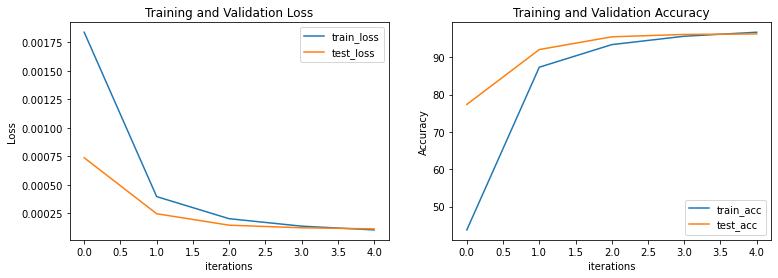

In [17]:
##train/test loop은 전에 정의했던 것을 그대로 쓰자
LR = 0.1 #learning rate는 setting해주기
EPOCHS = 5

#model, optimizer, criterion등등을 instantiate (to put in the train/test loop)
#여기서 알아두기 : lab1과 달리, train함수에 epoch 자체를 input으로 넣어주지 않음(대신 1 epoch 을 하는 train 함수를 여러번 돌림) 
model_light_CNN = light_CNN().to(DEVICE)
optimizer = torch.optim.SGD(model_light_CNN.parameters(), lr = LR)
criterion = nn.CrossEntropyLoss()
history = {'train_loss' : [], 'train_acc' : [], 'test_loss' : [], 'test_acc' : []}

for epoch in range(1, EPOCHS+1):
    train_loss, train_accuracy = train(model_light_CNN, train_loader, optimizer, criterion, epoch, DEVICE)
    test_loss, test_accuracy = evaluate(model_light_CNN, train_loader, criterion, DEVICE)
    print("\n[EPOCH: {}], \tModel: MNIST NET, \tLR: {:.4f}, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, optimizer.param_groups[0]['lr'], test_loss, test_accuracy))
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)

#위에서 정의했던 plot_history util함수를 써보자
plot_history(history)
    

## 3.3. Learning Rate Scheduler 를 통한 learning도중 learning rate 제어

> `torch.optim.lr_scheduler`를 써서 learning rate를 조절해주자

**learning rate scheduler**
* takes in optimizer instance (the optimizer whose lr we will update) as input
* `.step()` updates the lr value inside the optimizer

<br>


**learning rate scheduler 사용법**
1. 원하는 leraning rate scheduler를 import 
    * `from torch.optim.lr_scheduler import ExponentialLR`
2. **가지고 있는 `optimizer`** 를 가지고(`Optim`의 instance) lr_scheduler instance를 만들어주기
    * `scheduler = ExponentialLR(optimizer, gamma = 0.9)`
    * 즉, 일종의 "wrapping function"인듯? (함수의 함수이니?)
3. **training function내에서* epoch 마다 `scheduler.step()`으로 learning rate바꾸도록 하기
    * 이렇게 하면, wrapper function이 감싸고 있던 optimizer instance의 lr값을 바꾸게 된다


    
### 3.3.1. QnA. Learning Rate Scheduler 작동원리 : 
* 실제로 optimizer 내에있는 `optimizer.param_groups`라는 dictionary에 `lr` key에 해당하는 value값을 가져와서 수정해준다 (밑의 그림 참조)

 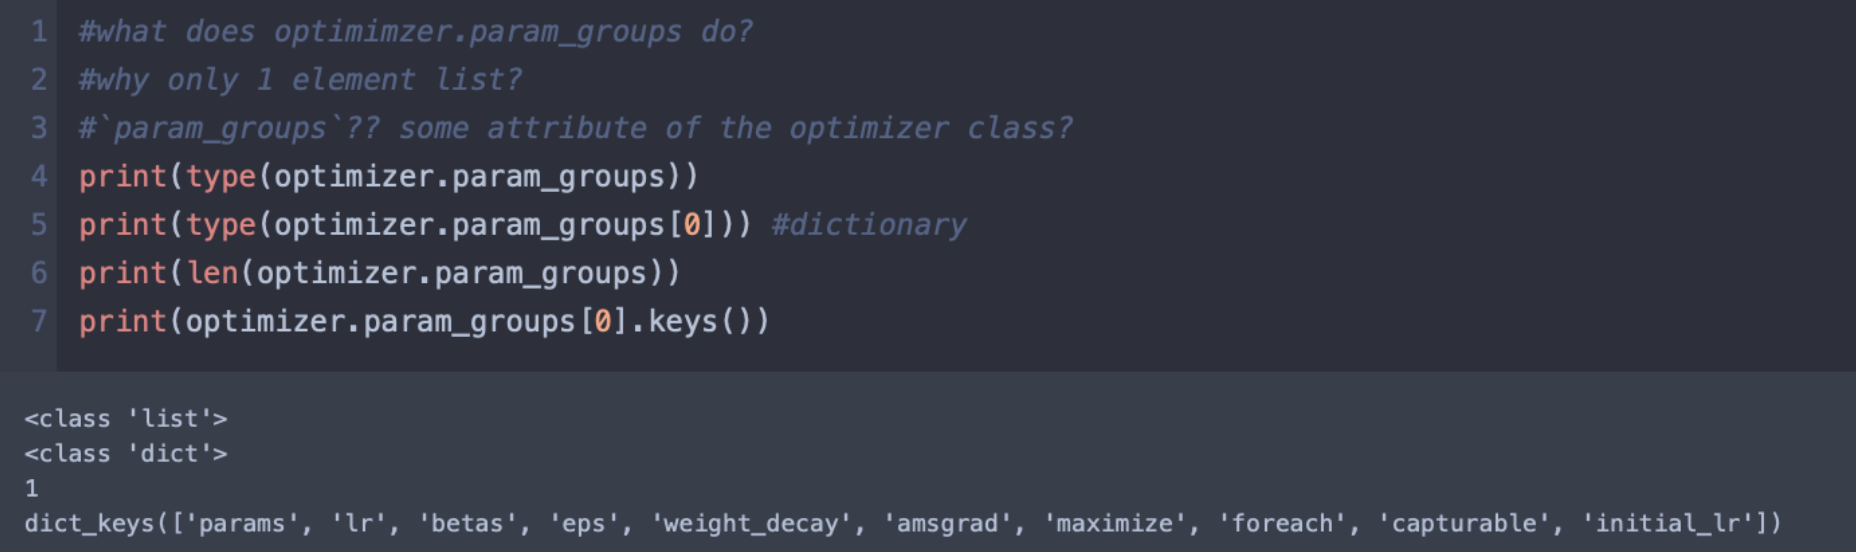


Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: MNIST NET, 	LR: 1.00e-03, 	Test Loss: 7.24e-05, 	Test Accuracy: 97.71 % 



Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]


[EPOCH: 2], 	Model: MNIST NET, 	LR: 1.00e-04, 	Test Loss: 5.04e-05, 	Test Accuracy: 98.41 % 



Epoch 3:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]


[EPOCH: 3], 	Model: MNIST NET, 	LR: 1.00e-05, 	Test Loss: 4.80e-05, 	Test Accuracy: 98.49 % 



Epoch 4:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]


[EPOCH: 4], 	Model: MNIST NET, 	LR: 1.00e-06, 	Test Loss: 4.78e-05, 	Test Accuracy: 98.50 % 



Epoch 5:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]


[EPOCH: 5], 	Model: MNIST NET, 	LR: 1.00e-07, 	Test Loss: 4.79e-05, 	Test Accuracy: 98.50 % 



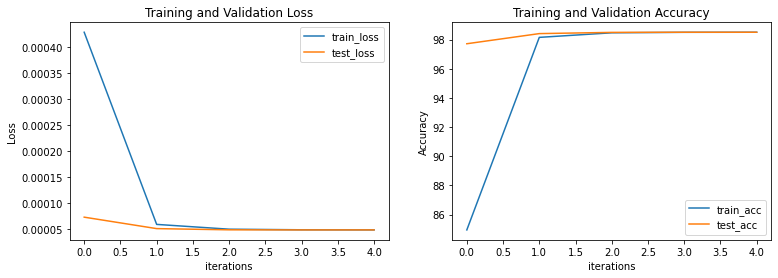

In [18]:
new_model_light_CNN = light_CNN().to(DEVICE) #DO NOT REUSE model_ligh_CNN(new set of parameters are needed)
optimizer = torch.optim.Adam(new_model_light_CNN.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1) #addedd scheduler!! 
#this scheduler takes in optimizer instance as input, which is expected!


history = {'train_loss' : [], 'train_acc' : [], 'test_loss' : [], 'test_acc' : []}

for epoch in range(1, EPOCHS+1):
    train_loss, train_accuracy = train(new_model_light_CNN, train_loader, optimizer, criterion, epoch, DEVICE, lr_scheduler)
    test_loss, test_accuracy = evaluate(new_model_light_CNN, train_loader, criterion, DEVICE)
    print("\n[EPOCH: {}], \tModel: MNIST NET, \tLR: {:.2e}, \tTest Loss: {:.2e}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, optimizer.param_groups[0]['lr'], test_loss, test_accuracy))
    
    ##saving the loss results at each epoch
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)
    
plot_history(history)

**결과보면** : 보다시피, lr_scheduler로 lr을 epoch갈수로 줄어줬기 때문에, 성능이 lr_scheduler안쓸때보다 더 좋은 것을 알 수 있다.


### Potential Question : `lr_scheduler.step()`이런거 언제함??
Answer : `train`함수 앞에서 정의했던 부분 잘보면
```
    if scheduler is not None: #i..e if scheduler was defined
        scheduler.step()
```
이게 batch다돌고 (즉, epoch하나 끝내면) 있었다는 것을 볼 수 있다)

In [19]:
#### some thigs to note:

'''
1. lr 실제로 바꾼후에 값이 얼만지 보고 싶으면, (위의 QnA에서 보았뜻이) `optimizer.param_groups`의 `'lr'`를 보면된다
'''

'''
2. scheduler update를  꼭 train내에서만 해줘야하는 것은 아님 (아무데서나 해도됨.. which is kinda obvious)
'''
print(optimizer.param_groups[0]['lr'])
lr_scheduler.step()
print(optimizer.param_groups[0]['lr'])
#보다시피, lr줄어든 것을볼 수 있다.
#왜 [0]을 한 "후"에 ['lr']인지는 모르겠다

1.0000000000000002e-07
1.0000000000000004e-08


# 4. Data Augmentation

## 4.0 기본적인 설명
Data Augmentation : data에 augmentation을 가해서, sample수를 늘리는 용도
(예시 : 똑같은 이미지의 cropped and uncropped image두개 모두 training할떄 쓴다)

<br>

**크게 두가지지의 type 존재**

1. **method1** :  input sample수 자체를 늘리기 ||  즉, 5만장 dataset => 5+10 만장 dataset (10만 from transform)
    * 장점 : RAM 아낄 수 있다
    * 단점 : more computation
    
2. **method2** : model 내부에서 forward pass할때마다 trnasform하기 || 즉,5만장 datset => 5만장 dataset (단 중간에 forward pass할때마다 random transform을 해줘서 transform마다 조금씩 달라진 5만장을 본다)
    * (randomness 때문에) 매번 forward pass할때마다 (같은 image여도) 다른 image를 보게 된다
    * 장점 : 매번 다르게 보기 때문에, model이 더 training이 잘되게 됨 (10번 epoch하면 10개의 다른 이미지를 보게 됨)
    * 단점 : computation이 좀 있다
    
    
즉, 두번째꺼는 transform 해서 dataaugmentatino하는 것이 model의 일부인 것! (like how pooling is part of the model)

## (3.4? 4?) Data Augmentation 
(flip, crop등등을 써서 sample갯수 늘려주는 것)

밑에서, transforms가 어떻게 우리가 정의한 dataset등등을 거치게 되는지 알아보자

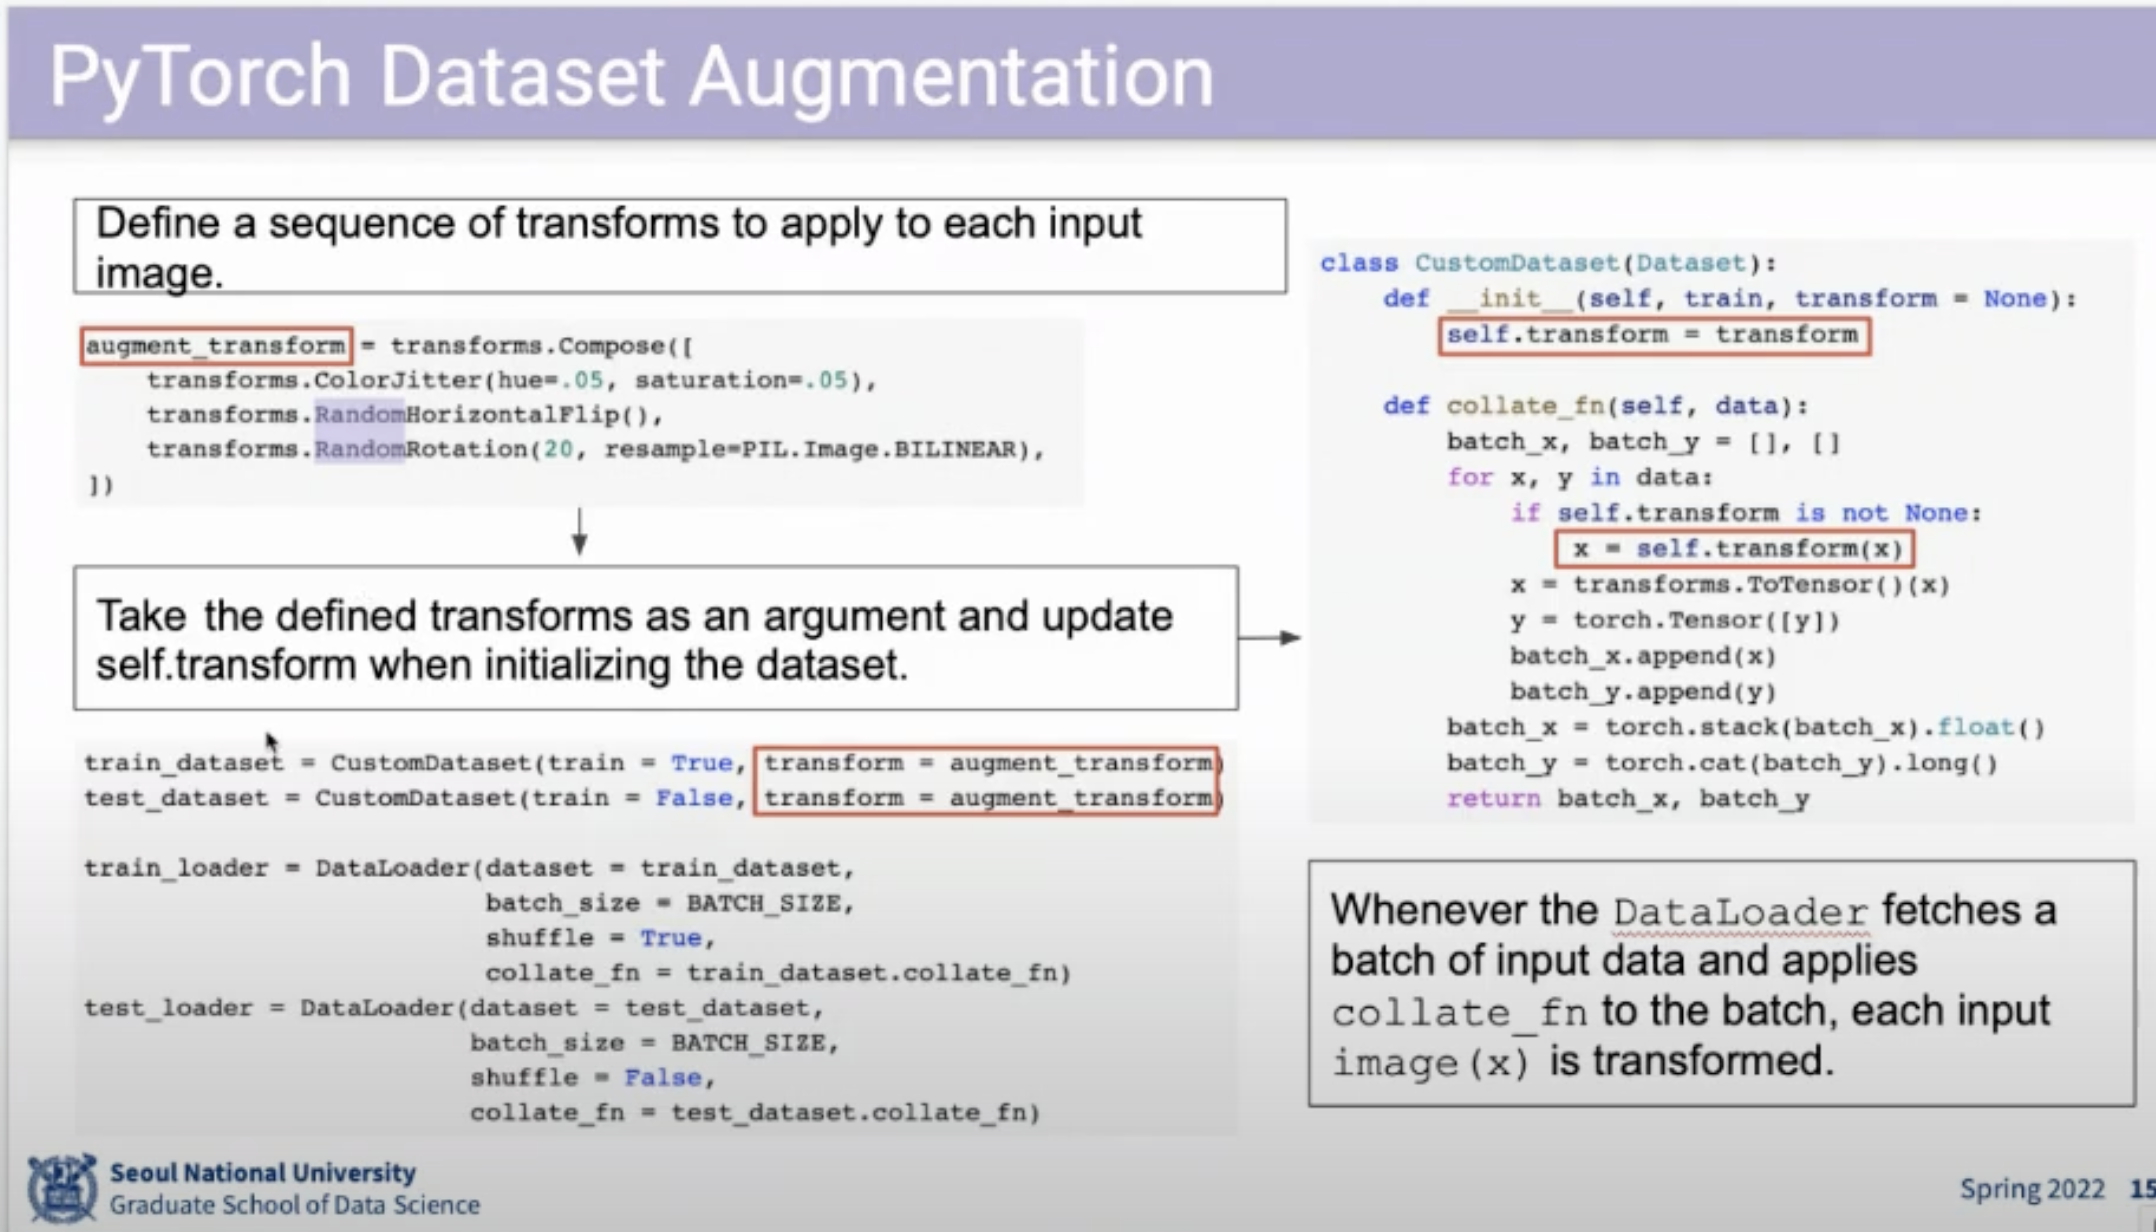

`transforms.Compose()` : `nn.Sequential`처럼 여러개를 한꺼번에 해줄 수 있다

따라서 이렇게 해줌으로서, augmented dataset (tensor)이 만들어진다


transform.Resize : size가 다른 dataset들의 경우 일정하게 맞춰주기 위한 것 (한번 적용해서 image결과 보기)

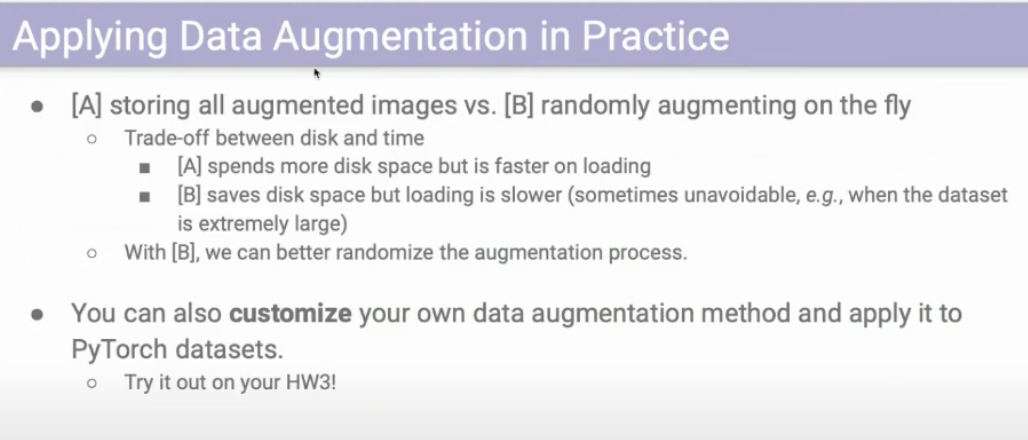


#### Pytorch에서 transform implement하는 방법 두가지

transformation 쓰는 두가지 방법
1. batch_x 자체에다가 적용해 주는 것 (이것은 3.1 에서 본다)
2. `Dataloader`의 `collate argument`로 넣어주기 (remember, collate_fn 은 pic => tensor로 만들어주는 건데, 여기서 transform을 할수도 있게 했었다 (이건 3.2에서 본다)
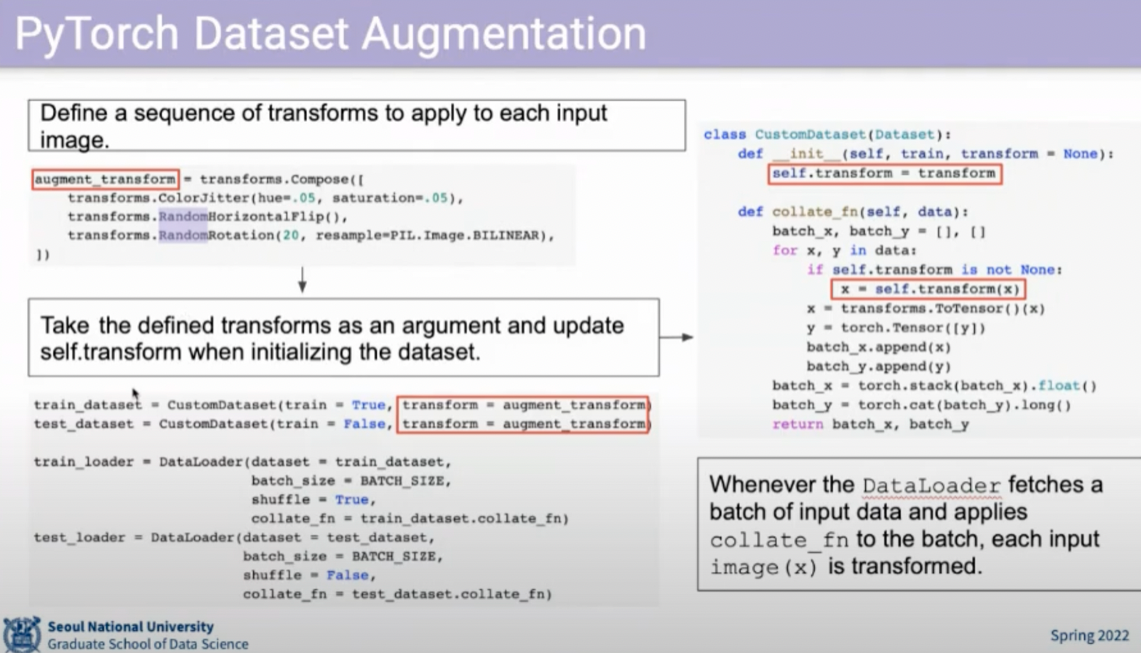




> 교수님 그거 미팅 잘못 된거 안한다고 말씀을 따로 드려야 할듯


> 금욜에 그거 휴가 신청해서 그거 들으러 가도 되는지


## 3.1. batch하나에 대해서만 해보기
일단 one batch에 대해서만 해보자
`plot_datset`: 앞에 utils에서 정의했던 것로,dataset을 plot하게 해줌 


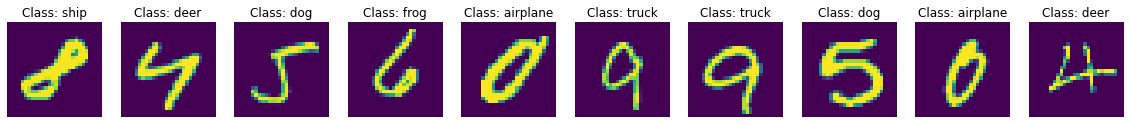

In [20]:
##before transform
batch_x, batch_y = next(iter(train_loader)) #just one batch


plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(batch_x[i], (1, 2, 0)))
    plt.title('Class: ' + str(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][batch_y[i].item()]))

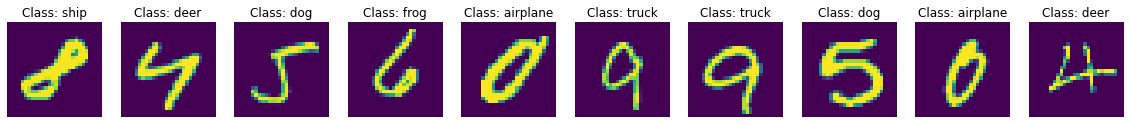

In [51]:
##after transform
transform_thingie = transforms.RandomHorizontalFlip(p = 0.5) #transform 함수 instance로 본다!
augment_x = transform_thingie(batch_x)


plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(augment_x[i], (1, 2, 0)))
    plt.title('Class: ' + str(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'][batch_y[i].item()]))

## 3.2. `DataLoader`에 `collate_fn`쓰서, data loading자체를 할떄 transform이 randomly하게 applied되게 하기

* `transform` instance를, 여러 transform instance를 합치는 `transforms.Compose`를 써서 만들자 (like `nn.Sequential`
* 따라서, **new dataloader, dataset** has to be defined (as below)

In [57]:
new_set_of_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
])
print(type(new_set_of_transforms))
print(new_set_of_transforms)


<class 'torchvision.transforms.transforms.Compose'>
Compose(
    RandomHorizontalFlip(p=0.3)
    RandomRotation(degrees=[-20.0, 20.0], interpolation=bilinear, expand=False, fill=0)
)


In [58]:
##defining new dataloader, this time with the transformation built in via collate_fn

train_dataset = CustomDataset(train = True, transform = new_set_of_transforms)
test_dataset = CustomDataset(train = False, transform = new_set_of_transforms) #당연하겠지만, testing할때도 transform을 해준데

print(type(train_dataset.collate_fn)) # 즉, collate_fn이라는 class method가 있다
                                      # with the `new_set_of_transforms` inside of it 
                                      # 이게, train_dataset.collate_fn으로, collate fn의 input으로 들어간다

train_loader = DataLoader(dataset = train_dataset,
                         batch_size = BATCH_SIZE,
                         shuffle = True,
                         collate_fn = train_dataset.collate_fn) #즉, 위에서 transform이 collate_fn attribute로 datset에 들어갔는데, 이것을 넣기

test_loader = DataLoader(dataset = test_dataset,
                        batch_size = BATCH_SIZE,
                        shuffle = False,
                        collate_fn = test_dataset.collate_fn)

Files already downloaded and verified
Files already downloaded and verified
<class 'method'>


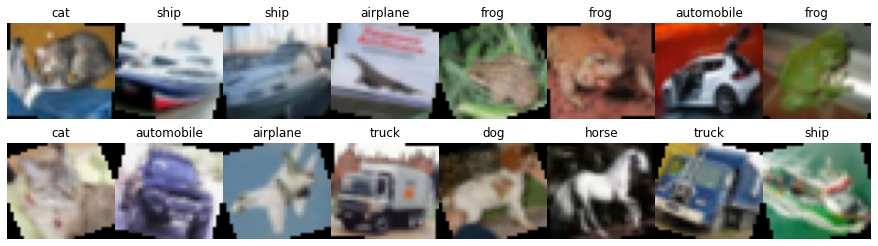

In [59]:
plot_dataset(test_loader)

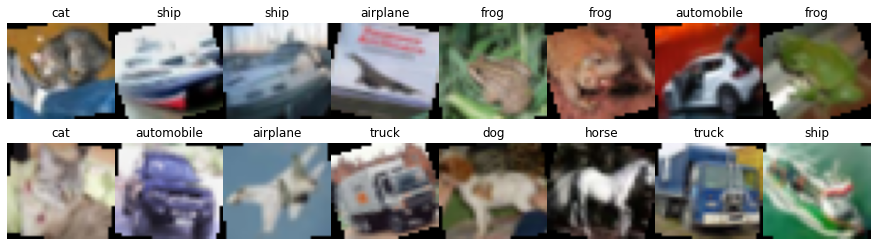

In [60]:
#똑같은 이미지를 다시한번 넣어보자 (iterator특성때문에 밑에처럼 코드가 조금 복잡함)
for _ in range(len(test_loader)-1):
    next(iter(test_loader))
plot_dataset(test_loader)

In [ ]:
#print(help(transforms.RandomHorizontalFlip))

In [ ]:
#augment라는 함수에 batch에서 뽑아온 그 augment하는 것 (np.transpose : pytroc에서 그거 맞춰주는 것)

In [ ]:
#이제 예시를 봤으니 이제 어디다가 넣느냐?
#dataloader할때 transform에 넣어주기
#collate_fn정의할때 했던 것이 들어간다


In [ ]:
#x = torch.arange(start = 10, end = 18).reshape(2,4)
x = torch.arange(2*3*4*4).reshape(2,3,4,4)

#print(x)
print(x.shape)
print("========")
print(x.max())
print("========")
#print(x.max(0))
print(x.max(0)[0].shape, x.max(0)[1].shape)
print("========")
#print(x.max(1))
print(x.max(1)[0].shape, x.max(1)[1].shape)
print("\n========")
print(x.max(1,keepdim = True))

print("\n========")
print(x.max(1,keepdim = True)[1])
#torch.max?

In [ ]:
print(len(train_loader.dataset), len(train_loader))
torch.arange?

In [ ]:
#nn.Conv2d?
nn.MaxPool2d?

In [ ]:
datasets.CIFAR10?

## Multilayer perceptron  
저번꺼랑 똑같음 (just baseline)(그래서 맨 뒤로 보냄)(유일하게 다른점 : some dimensions are changed (color channel 3))

* 참고로 밑에서 tqdm을 쓰는데 이것은 X 보충설명에 적어놓음

## 잘 작동안함!! debugging 하기!!!(find out why test loss doesn't decrease)

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512) #32*32*3 because 32*32 size, 3 : channel size
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = x.reshape(-1, 32*32*3) #flattening it #.view(-1, 32*32*3)으로 해도 되기는 하다 
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim = 1)
        return x

## ASK : `tqdm` and `train_loader` and `PIL` and so on => how to loop thorugh them and manage them.... something I can look up? (iterable object...?)

In [ ]:
def train(model, train_loader, optim, criterion, scheduler = None):
    model.train() #train model remember
    train_loss = 0
    correct = 0
    
    #settinge the tqdm_bar (epoch here refers to the epoch, not the iteration)
    tqdm_bar = enumerate(tqdm(train_loader, desc = "TRAIN | Epoch {} : ".format(epoch)))    
    #tqdm_bar = tqdm(enumerate(train_loader))
    for batch_idx, (X, y) in tqdm_bar :
        optim.zero_grad() #initilaize remember? (for each batch)
        X = X.to(DEVICE)      #send things ot the device
        y = y.to(DEVICE)
        
        #backprop/optimize
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optim.step()
        
        #calculate train/test loss/acc
        train_loss += loss.item()
        prediction = output.max(1, keepdim = True)[1] #확률화 시키기
        correct += prediction.eq(y.view_as(prediction)).sum().item()

    if scheduler is not None:
        scheduler.step() #lr scheduler decays the learning rate each epoch 
        
    #batch train loss/acc
    train_loss /= len(train_loader.dataset)              #i.e. batch 가 된 train_loader이 아닌 그 어머니인 dataset의 size (i.e. total sample number)
    train_acc = 100. * correct/ len(train_loader.dataset) #이것도 마찬가지
    
    return train_loss, train_acc    

In [ ]:
def evaluate(model, test_loader, criterion):
    model.eval()      #EVALUATION MODE REMEMBER
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for X, y in tqdm(test_loader, desc = "TEST | Epoch {} : ".format(epoch)):
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            
            output = model(X)
            test_loss += criterion(output, y).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(y.view_as(prediction)).sum().item() #여기서는 number of items (not batches) that are correct 
                                                        #(because 1D boolean array 의 합을 보니)
        #normalize to batch
        test_loss /= len(test_loader.dataset)
        test_acc = 100. * correct/len(test_loader.dataset)
    return test_loss, test_acc

In [ ]:
model_MLP = MLP().to(DEVICE)
optimizer = torch.optim.Adam(model_MLP.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model_MLP) #let's look at the model
#print(optimizer)

In [ ]:
for epoch in range(10):
    train(model_MLP, train_loader, optimizer, criterion) #trn_loss, trn_acc = t
    tst_loss, tst_acc = evaluate(model_MLP, test_loader, criterion)
    print("\n[EPOCH: {}], \tModel: MLP, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, tst_loss, tst_acc))
    #print("\n[EPOCH: {}], \tModel: MLP, \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f}% \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(epoch, trn_loss, trn_acc, tst_loss, tst_acc))

In [ ]:
evaluate(model, test_loader, criterion)

## X. 보충설명

### X.1 tqdm + dataloder loop 어떻게 쓰이는지 보기(예시로 보기, 개념설명은 생략)
* `tqdm(iterable)`을 쓴다

In [ ]:
#simple example
import time
for i in tqdm(range(100)):
    time.sleep(0.05)
    pass

#doing it on an array

a = np.arange(5)
for i, sample in tqdm(enumerate(a)):
    print(sample)
    
#이제 이것을 train_loader에다가 적용해보자

In [ ]:
#일단은 train_loader은 for loop으로 하나씩 뺄 수 있는 object 이다
for (b,c) in train_loader:
    print(b.shape)
    print(c.shape)
    break

In [ ]:
#이것을 enumerate해보자
for i, (b,c) in enumerate(train_loader) : 
    print(i, b.shape, c.shape)
    if i==5 :  #6개 까지만 하기
        break

In [ ]:
#enumerate한것을 tqdm해보자 (progress tracking)(밑에 보기)
tqdm_bar = tqdm(enumerate(train_loader)) #notice : tqdm만 둘른 것
for i, (b,c) in tqdm_bar: #same as `tqdm(enumerate(train_loader))`
    tqdm_bar.set_description("this is the description") #set descriptoin
    if i ==5:
        break
#print('\n')
#print(a,c)

In [ ]:
#위의 세개가 각각 어떤 class에 속하는 object인지 (and hence have differnt charcters)를 밑에서 보기가능
print(type(train_loader))
print(type(enumerate(train_loader)))
print(type(tqdm(enumerate(train_loader))))

In [ ]:
print(type(enumerate(tqdm(train_loader))))

In [ ]:
####이것 하기!!
tqdm_bar = enumerate(tqdm(train_loader, desc = "this is the description")) #have to set as "desc"
for i, (b,c) in tqdm_bar: #same as `tqdm(enumerate(train_loader))`
    time.sleep(0.05)

## supplementary info

### data type used in ML (especially neurosci)
* float 16, 32이런 것도 가능하나, 우리가 하는 것에서는 큰 이득이 없다 (오히려 computational cost만 증가)
    * edge device : 부피를 줄이기 위해 8bit을 쓴다던가 그렇기는 한다
* gradient를 16, 32비트로 계산한는 것이 있기는 하나 큰 차이는 없다 (보통은 속도 향상을 위한 mixed precision을 쓸때도 있다(https://hoya012.github.io/blog/Mixed-Precision-Training/)
* **뇌영상** : 보통 min/max scaling or standardization 을 거친  float 16 bit를 쓴다 (but optimize시킬 시간에 다른 것을 하는게 더 좋다)(연구에서는)

### tqdm, enumerate등등 사용하는 것
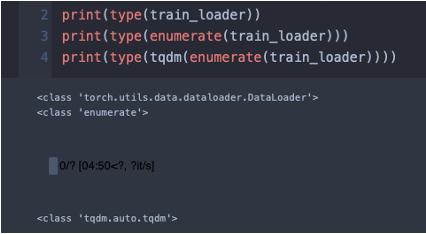
* type loader를 보면 dataloader이다. 이것을 for loop으로 돌리면, generaotr함수가 있어서 for loop을 돌릴떄 마다 dataloader에 있는 dataset을 io해서 불러오는 것 
* enumreate는 for loop을 하되, index도 같이 나오게 하기 위해서 하는 것 

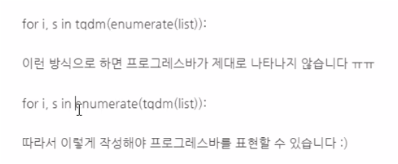